In [39]:
import numpy as np
import time
import cv2
from matplotlib import pyplot as plt
from nms import nms as nms
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
# Load COCO class labels
labelsPath = './yolo-coco/coco.names'
labels = open(labelsPath).read().strip().split('\n')
print("Number of labels:", len(labels))

Number of labels: 25


In [3]:
print(labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'parking meter', 'bench', 'backpack', 'umbrella', 'handbag', 'skis', 'snowboard', 'kite', 'cup', 'bowl', 'chair', 'pottedplant', 'tvmonitor', 'cell phone']


In [4]:
# Associate each label with a certain color
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

In [5]:
# Constants to use with YOLO
min_confidence = 0.5
min_threshold = 0.3

In [6]:
configPath = './yolo-coco/yolov3.cfg'
weightsPath = './yolo-coco/yolov3.weights'

# Load YOLO Object detector trained on COCO dataset
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

In [33]:
def get_boxes_and_confidences(layerOutputs, boxes, confidences, classIDs, width, height):
    for output in layerOutputs:
        for detection in output:
            # Get classID and confidence from object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Filter out weak predictions
            if confidence > min_confidence:
                box = detection[0:4] * np.array([width, height, width, height])
                (centerX, centerY, box_width, box_height) = box.astype('int')

                # Get top left corner of the box
                x = int(centerX - (box_width/2))
                y = int(centerY - (box_height/2))

                # Update boxes, confidences, and classIDs
                if (classID < len(labels)):
                    boxes.append([labels[classID], x, y, int(box_width), int(box_height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

In [8]:
def draw_boxes(idxs, image, boxes, classIDs, confidences):
    if len(idxs) > 0: # If object was detected only
        for i in idxs.flatten():
            # Get bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # Draw bounding box
            try:
                color = [int(c) for c in colors[classIDs[i]]]
                cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
                text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
                cv2.putText(image, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                print(labels[classIDs[i]], confidences[i])
            except IndexError:
                print("Invalid ID " + str(classIDs[i]))

In [9]:
def get_yolo_boxes(image_path):
    # Get image and details
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    (height, width) = image.shape[:2]
    
    # Get output layer names from YOLO Model
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # Construct a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    # Forward pass through YOLO Network
    layerOutputs = net.forward(ln)
    
    boxes = [] # Bounding boxes
    confidences = [] # Confidence values assigned to an object
    classIDs = [] # objects' class label
    get_boxes_and_confidences(layerOutputs, boxes, confidences, classIDs, width, height)
    return boxes, confidences

In [10]:
image_path_3 = './data_object_image_2/testing/image_2/001061.png'
get_yolo_boxes(image_path_3)

([['car', 706, 194, 414, 180],
  ['car', 716, 197, 398, 183],
  ['car', 566, 179, 52, 59],
  ['bus', 608, 157, 177, 113],
  ['car', 504, 182, 24, 17],
  ['car', 543, 187, 34, 35],
  ['car', 564, 186, 35, 52]],
 [0.9966422915458679,
  0.9864318370819092,
  0.7684740424156189,
  0.679132342338562,
  0.5853825807571411,
  0.7661823034286499,
  0.5981326699256897])

In [11]:
def get_actual_boxes(mask_directory):
    bound_boxes = []
    with open(mask_directory) as f:
        content = f.readlines()
    contents = [x.split() for x in content]
    for content in contents:
        obj = content[0]
        if (obj in ['Car', 'Truck', 'Van']): # Get pixels containing a vehicle
            start_col = int(float(content[4]))
            start_row = int(float(content[5]))
            end_col = int(float(content[6]))
            end_row = int(float(content[7]))
            if obj in ['Truck', 'Van']:
                obj_name = 'truck'
            else:
                obj_name = 'car'
            bound_boxes.append((obj_name, start_row, end_row, start_col, end_col))
    return bound_boxes

In [12]:
mask_path_2 = './data_object_image_2/training/label_2/000061.txt'
get_actual_boxes(mask_path_2)

[('truck', 105, 249, 1054, 1241),
 ('car', 212, 328, 0, 41),
 ('car', 217, 254, 69, 112),
 ('car', 218, 297, 0, 93),
 ('truck', 123, 169, 884, 923)]

In [13]:
def draw_actual_boxes(image, boxes):
    for i in range(0, len(boxes)):
        # Get bounding box coordinates
        (x, y) = (boxes[i][1], boxes[i][2])
        (w, h) = (boxes[i][3], boxes[i][4])

        # Draw bounding box
        color = (255,0,0)
        cv2.rectangle(image, (boxes[i][3], boxes[i][1]), (boxes[i][4], boxes[i][2]), color, 2)

In [14]:
def get_and_draw_actual_boxes(img_path, mask_directory):
    # Get image and details
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get boxes from label data
    boxes = get_actual_boxes(mask_directory)
    #print(classIDs)
    print(boxes)
    
    draw_actual_boxes(image, boxes)
    plt.imshow(image)
    plt.show()

[('truck', 105, 249, 1054, 1241), ('car', 212, 328, 0, 41), ('car', 217, 254, 69, 112), ('car', 218, 297, 0, 93), ('truck', 123, 169, 884, 923)]


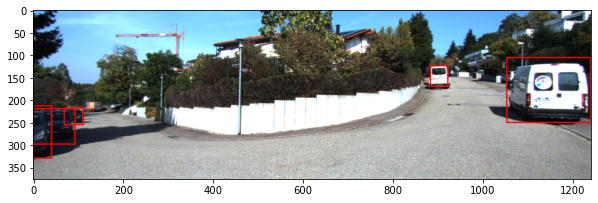

In [15]:
image_path_2 = './data_object_image_2/training/image_2/000061.png'
mask_path_2 = './data_object_image_2/training/label_2/000061.txt'

get_and_draw_actual_boxes(image_path_2, mask_path_2)

## Calculating Mean Average Precision

### Get Intersection-Over-Union Between Two Boxes

In [16]:
def calc_iou(actual_box, pred_box):
    boxA = pred_box
    boxB = actual_box

    xA = max(boxA[1], boxB[1])
    yA = max(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])
    yB = min(boxA[4], boxB[4])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[3] - boxA[1] + 1) * (boxA[4] - boxA[2] + 1)
    boxBArea = (boxB[3] - boxB[1] + 1) * (boxB[4] - boxB[2] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [31]:
def bb_intersection_over_union(image_path, mask_path, iou_threshold=0.6):
    predicted_boxes, confidences = get_yolo_boxes(image_path) # x_start, y_start, x_end, y_end
    predicted_boxes_no_labels = [detection[1:] for detection in predicted_boxes]
    best_box_indices = nms.boxes(predicted_boxes_no_labels, confidences, nms_threshold=0.6)
    # Instead of (x, y, w, h), return (x, y, x+w, y+h)
    for box in predicted_boxes:
        box[3] = box[3] + box[1]
        box[4] = box[4] + box[2]
    predicted_boxes = [predicted_boxes[i] for i in best_box_indices]
    
    actual_boxes = get_actual_boxes(mask_path_2) # y_start, y_end, x_start, x_end
    # Rearrange actual_boxes to fit the same format
    actual_boxes_reordered = []
    for box in actual_boxes:
        actual_boxes_reordered.append((box[0], box[3], box[1], box[4], box[2]))
    
    # Sort rectangles in each list
    predicted_boxes = sorted(predicted_boxes, key=lambda x: x[1])
    actual_boxes_reordered = sorted(actual_boxes_reordered, key=lambda x: x[1])
    
    #print("Predicted Boxes:", predicted_boxes)
    #print("Actual Boxes:", actual_boxes_reordered)
    
    predicted_labels = [i[0] for i in predicted_boxes]
    actual_labels = [i[0] for i in actual_boxes_reordered]
    #print(predicted_labels)
    #print(actual_labels)
    
    actual_idx_thr = []
    pred_idx_thr = []
    ious = []
    
    tp = 0
    fp = 0
    fn = 0
    # Try to find pairs of boxes (between actual and predicted) that are the best fit
    for ipb, pred_box in enumerate(predicted_boxes):
        for iab, actual_box in enumerate(actual_boxes_reordered):
            iou = calc_iou(actual_box, pred_box)
            if iou > iou_threshold:
                #print(iou)
                actual_idx_thr.append(iab)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sorted = np.argsort(ious)[::1]
    if len(iou_sorted) == 0:
        tp = 0
        fp = len(predicted_boxes)
        fn = len(actual_boxes_reordered)
        precision = 0.0
        recall = 0.0
        #print("tp=0, fp=0, fn=0")
    else:
        actual_match_idx = []
        pred_match_idx = []
        for idx in iou_sorted:
            actual_idx = actual_idx_thr[idx]
            pred_idx = pred_idx_thr[idx]
            # If boxes are unmatches, add them to matches
            if (actual_idx not in actual_match_idx) and (pred_idx not in pred_match_idx):
                actual_match_idx.append(actual_idx)
                pred_match_idx.append(pred_idx)
        tp = len(actual_match_idx)
        fp = len(predicted_boxes) - len(pred_match_idx)
        fn = len(actual_boxes_reordered) - len(actual_match_idx)
        #print("TP =", tp, "FP =", fp, "FN =", fn)
        precision = float(tp)/(tp+fp)
        recall = float(tp)/(tp+fn)
    #print(precision, recall)
    return precision, recall
            
    
    #if (len(predicted_boxes) != len(actual_boxes_reordered)):
    #    print("Number of objects detected do not match for:", image_path)
    #else:
    #    # Calculate IOU
    #    for i in range(0, len(predicted_boxes)):
    #        print(calc_iou(actual_boxes_reordered[i], predicted_boxes[i]))

In [22]:
# Test bb_intersection_over_union() function
image_path_2 = './data_object_image_2/training/image_2/000061.png'
mask_path_2 = './data_object_image_2/training/label_2/000061.txt'

bb_intersection_over_union(image_path_2, mask_path_2)

(1.0, 1.0)

In [43]:
def get_error_for_all_images():
    precisions = []
    recalls = []
    
    for i in tqdm(range(7481)): # Full training size: 7481
        image_no = str(i).zfill(6)
        image_path = './data_object_image_2/training/image_2/' + image_no + '.png'
        mask_path = './data_object_image_2/training/label_2/' + image_no + '.txt'
        prec, recall = bb_intersection_over_union(image_path, mask_path)
        precisions.append(prec)
        recalls.append(recall)
    
    return precisions, recalls

In [44]:
# Call bb_intersection_over_union on all images in training set
# Create a list of precision and recall values
precisions, recalls = get_error_for_all_images()

precisions = np.array(precisions)
recalls = np.array(recalls)
prec_at_rec = []
np.linspace(0.0, 1.0, 11)
for recall_level in np.linspace(0.0, 1.0, 11):
    try:
        args = np.argwhere(recalls > recall_level).flatten()
        prec = max(precisions[args])
        print(recalls, "Recall")
        print(recall_level, "Recall Level")
        print(args, "Args")
        print(prec, "precision")
    except ValueError:
        prec = 0.0
    prec_at_rec.append(prec)
avg_prec = np.mean(prec_at_rec)


100%|██████████| 7481/7481 [52:34<00:00,  2.37it/s] 

[0. 0. 0. ... 0. 0. 0.] Recall
0.0 Recall Level
[  61  857 1199 1263 1481 1673 2056 2082 2136 2205 2295 2409 2540 3051
 3067 3086 3335 4169 4818 4845 4870 4883 4916 4962 5076 5090 5152 5229
 5242 5490 5496 5571 5640 5858 5900 5959 6154 6394 6622 6624 6919 6967
 7218 7238 7259] Args
1.0 precision
[0. 0. 0. ... 0. 0. 0.] Recall
0.1 Recall Level
[  61  857 1199 1263 1481 1673 2056 2082 2136 2205 2295 2409 2540 3051
 3067 3086 3335 4169 4818 4845 4870 4883 4916 4962 5076 5090 5152 5229
 5242 5490 5496 5571 5640 5858 5900 5959 6154 6394 6622 6624 6919 6967
 7218 7238 7259] Args
1.0 precision
[0. 0. 0. ... 0. 0. 0.] Recall
0.2 Recall Level
[  61 5900] Args
1.0 precision
[0. 0. 0. ... 0. 0. 0.] Recall
0.30000000000000004 Recall Level
[  61 5900] Args
1.0 precision
[0. 0. 0. ... 0. 0. 0.] Recall
0.4 Recall Level
[61] Args
1.0 precision
[0. 0. 0. ... 0. 0. 0.] Recall
0.5 Recall Level
[61] Args
1.0 precision
[0. 0. 0. ... 0. 0. 0.] Recall
0.6000000000000001 Recall Level
[61] Args
1.0 precision
[

In [45]:
print("Mean average precision:", avg_prec)

Mean average precision: 0.9090909090909091


In [48]:
print(len(precisions))
print(len(recalls))
print(prec_at_rec)

7481
7481
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
